In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from utils.base_helpers import read_data, split_data, plot_metrics
from utils.tf_helpers import WindowGenerator, compile_and_fit
from scripts.tf_models import BaseTFModel

2022-04-16 23:29:38.723714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-16 23:29:38.723733: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-16 23:29:44.653393: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-16 23:29:44.653434: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (algopoly): /proc/driver/nvidia/version does not exist


In [4]:
df = read_data(generate_speed_angle=True, add_lagged=True, number_of_plants=1)

Selected plants:
 [969]


In [5]:
train_df_np, valid_df_np, test_df_np = split_data(df, train_ratio=0.8, valid_ratio=0.1, scaler="minmax")

Train start and end dates:  2019-01-26 03:00:00 2021-06-22 09:00:00
Validation start and end dates:  2021-06-22 10:00:00 2021-10-10 04:00:00
Test start and end dates:  2021-10-10 05:00:00 2022-01-27 23:00:00


In [6]:
OUT_STEPS = 24
INPUT_WIDTH = 48

window = WindowGenerator(
    train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, 
    columns=[col for col in df.columns if col != "rt_plant_id"],
    input_width=INPUT_WIDTH, label_width=24, shift=0, label_columns=["production"])
window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['production']

In [7]:
val_performance = {}
performance = {}

# Dense

## Linear2

In [14]:
class Linear2(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Dense(self.OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        return model
    
model = Linear2(window).model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 48, 1, 17)         0         
                                                                 
 dense_6 (Dense)             (None, 48, 1, 24)         432       
                                                                 
 dropout_3 (Dropout)         (None, 48, 1, 24)         0         
                                                                 
 end-------- (Reshape)       (None, 1, 1152)           0         
                                                                 
 dense_7 (Dense)             (None, 1, 24)             27672     
                                                                 
 permute_4 (Permute)         (None, 24, 1)             0         
                                                                 
 reshape_4 (Reshape)         (None, 24, 1, 1)         

In [28]:
val_performance = {}
performance = {}

param_list = [
    {"loss": "mse", "optimizer": "rmsprop"},
    {"loss": "mse", "optimizer": "adam"},
    {"loss": "binary_crossentropy", "optimizer": "rmsprop"},
    {"loss": "binary_crossentropy", "optimizer": "adam"},
]

for param_dict in param_list:
    model, history = compile_and_fit(model, window, max_epochs=20, verbose=0, **param_dict)
    val_performance["-".join(param_dict.values())] = model.evaluate(window.valid)
    performance["-".join(param_dict.values())] = model.evaluate(window.test)


2/2 [==============================] - 0s 1ms/step - loss: 0.5495 - wmape: 0.3943


In [29]:
performance

{'mse-rmsprop': [0.029716994613409042, 0.3594488501548767],
 'mse-adam': [0.029865184798836708, 0.3559226989746094],
 'binary_crossentropy-rmsprop': [0.5682259202003479, 0.3603368401527405],
 'binary_crossentropy-adam': [0.5494567155838013, 0.3943316340446472]}

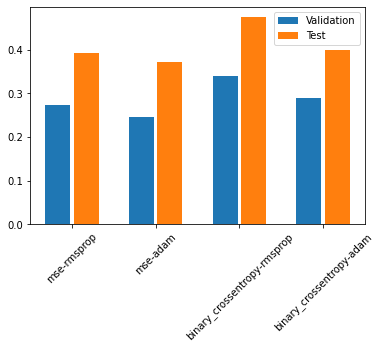

In [27]:
from utils.base_helpers import plot_metrics
plot_metrics(performance, val_performance)

# Conv

## Conv4

In [31]:
CONV_WIDTH = 5
class Conv4(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Conv2D(64, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        model.add(layers.Conv2D(32, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        return model
    
model = Conv4(window).model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 48, 1, 17)         0         
                                                                 
 permute_6 (Permute)         (None, 1, 48, 17)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 48, 64)         27264     
                                                                 
 permute_7 (Permute)         (None, 48, 64, 1)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 32, 1)        0         
 )                                                               
                                                                 
 permute_8 (Permute)         (None, 1, 24, 32)         0         
                                                      

In [33]:
model, history = compile_and_fit(model, window, max_epochs=10, verbose=1, loss="mse", optimizer="adam")
val_performance["CNN"] = model.evaluate(window.valid)
performance["CNN"] = model.evaluate(window.test)


Epoch 1/10
      0/Unknown - 4s 0s/sample - loss: 0.0346 - wmape: 0.4298
Epoch 1: val_wmape improved from inf to 0.25008, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 4s 11ms/sample - loss: 0.0346 - wmape: 0.4294 - val_loss: 0.0198 - val_wmape: 0.2501
Epoch 2/10
  0/329 [..............................] - ETA: 0s - loss: 0.0207 - wmape: 0.3304
Epoch 2: val_wmape improved from 0.25008 to 0.24166, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 3s 10ms/sample - loss: 0.0207 - wmape: 0.3307 - val_loss: 0.0181 - val_wmape: 0.2417
Epoch 3/10
  0/329 [..............................] - ETA: 0s - loss: 0.0187 - wmape: 0.3123
Epoch 3: val_wmape did not improve from 0.24166
329/329 [==============================] - 3s 10ms/sample - loss: 0.0186 - wmape: 0.3122 - val_loss: 0.0201 - val_wmape: 0.2486
Epoch 4/10
  0/329 [..............................] - ETA: 0s - loss: 0.0172 - wm

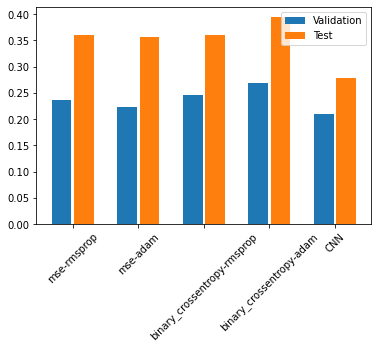

In [34]:
plot_metrics(performance, val_performance)